In [1]:
#| include: false

import duckdb
import pandas as pd
%load_ext sql

%config SqlMagic.autopandas = True
%config SqlMagic.feedback = False
%config SqlMagic.displaycon = False

%sql duckdb:///:memory:

%sql CREATE OR REPLACE TABLE user_actions AS SELECT * FROM read_csv('00_data/sql/user_actions.csv', header=True, columns={'user_id': 'INT', 'order_id': 'INT', 'action': 'VARCHAR', 'time': 'TIMESTAMP'}, timestampformat='%d/%m/%y %H:%M');
%sql CREATE OR REPLACE TABLE courier_actions AS SELECT * FROM read_csv('00_data/sql/courier_actions.csv', header=True, columns={'courier_id': 'INT', 'order_id': 'INT', 'action': 'VARCHAR', 'time': 'TIMESTAMP'}, timestampformat='%d/%m/%y %H:%M');
%sql CREATE OR REPLACE TABLE orders AS SELECT * FROM read_csv('00_data/sql/orders.csv', header=True, columns={'order_id': 'INT', 'creation_time': 'TIMESTAMP', 'product_ids': 'INT[]'}, timestampformat='%d/%m/%y %H:%M');
%sql CREATE OR REPLACE TABLE users AS SELECT * FROM read_csv('00_data/sql/users.csv', header=True, columns={'user_id': 'INT', 'birth_date': 'DATE', 'sex': 'VARCHAR'}, dateformat='%d/%m/%y');
%sql CREATE OR REPLACE TABLE couriers AS SELECT * FROM read_csv('00_data/sql/couriers.csv', header=True, columns={'courier_id': 'INT', 'birth_date': 'DATE', 'sex': 'VARCHAR'}, dateformat='%d/%m/%y');
%sql CREATE OR REPLACE TABLE products AS SELECT * FROM read_csv('00_data/sql/products.csv', header=True, columns={'product_id': 'INT', 'name': 'VARCHAR', 'price': 'DOUBLE'});

The sql extension is already loaded. To reload it, use:
  %reload_ext sql


,Count
0,87


# Об'єднання таблиць

## Основні типи об'єднань JOIN

Ось ми й підібралися до однієї з найважливіших тем у SQL – об'єднання таблиць.

SQL-запити дозволяють вибирати та обробляти дані не тільки з однієї таблиці – у цьому ми вже переконалися, коли працювали з підзапитами. Але таблиці можна об'єднувати в один результуючий набір записів, пов'язуючи їх за певними умовами. Це дозволяє робити операція з'єднання `JOIN`.

Ми розглянемо такі типи з'єднань таблиць:

1. `INNER JOIN`
2. `LEFT/RIGHT JOIN`
3. `FULL JOIN`
4. `CROSS JOIN`

Оператори об'єднання включаються до розділу `FROM` запиту. Загалом, незалежно від того, який тип об'єднання використовується, запит на об'єднання таблиць виглядає наступним чином:

```sql
SELECT ...
FROM table_1 
     JOIN table_2
     ON [condition]
```

Як правило (але далеко не завжди), в якості умови **[condition]**, за якою відбувається об'єднання, виступає рівність значень у певних стовпцях. Такі стовпці зазвичай використовуються як ключі із зазначенням id (товару, користувача тощо), тобто значень, за якими можна однозначно ідентифікувати певну сутність:

```sql
SELECT table_1.column_1, table_2.column_2
FROM table_1 
     JOIN table_2
     ON table_1.id = table_2.id
```

При цьому рекомендується до кожної колонка через точку вказувати ім'я таблиці, яка містить цю колонку. Більше того, це стає вже не рекомендацією, а необхідністю, коли імена стовпців у таблицях збігаються - без явного вказівки джерел, база даних не зможе сама визначити, які стовпці та з яких таблиць ви маєте на увазі, і в результаті поверне помилку.

Якщо імена таблиць надто довгі, таблицям можна присвоїти аліаси. За цими ж аліасами можна відразу зручно звертатися до колонок:

```sql
SELECT a.column_1, b.column_2
FROM table_1 a 
     JOIN table_2 b
     ON a.id = b.id
```

Якщо ім'я поля, за котрим відбувається об'єднання, збігається в обох таблицях (як у прикладах вище), можна використовувати скорочений запис з оператором `USING`:

```sql
SELECT a.column_1, b.column_2
FROM table_1 a 
     JOIN table_2 b
     USING (id)
```

При об'єднанні таблиць можна використовувати підзапити. Їх можна поєднувати з іншими таблицями або одину з одною:

```sql
SELECT ...
FROM table_1
     JOIN (
          SELECT ...
          FROM table_2
     ) AS subquery
    ON table_1.id = subquery.id
...


SELECT ...
FROM (
     SELECT ...
     FROM table_1
) AS subquery_1
     JOIN (
          SELECT ...
          FROM table_2
     ) AS subquery_2
    ON subquery_1.id = subquery_2.id
...
```

## Як працює об'єднання таблиць

Добре, із записом у загальному вигляді начебто зрозуміло. Але що насправді відбувається при об'єднанні таблиць? Давайте розбиратися.

Процес об'єднання можна подати у вигляді наступної послідовності операцій:

1. Спочатку кожен рядок першої таблиці зіставляється з кожним рядком другої таблиці, тобто відбувається [декартів добуток](https://uk.wikipedia.org/wiki/%D0%94%D0%B5%D0%BA%D0%B0%D1%80%D1%82%D1%96%D0%B2_%D0%B4%D0%BE%D0%B1%D1%83%D1%82%D0%BE%D0%BA_%D0%BC%D0%BD%D0%BE%D0%B6%D0%B8%D0%BD) вдох множин, результатом якого є нове множина, що складається з різних пар вхідних рядків. Наприклад, якщо у одній таблиці було 50 записів, а інший 10, то результаті декартового добутку вийде 500 записів. На іграшковому прикладі це можна уявити так:

![Декартів добуток](img/sql/cartesian.png){#fig-cartesian width=45%}

2. Потім для кожного об'єднаного рядка, що складається з двох вхідних таблиць, перевіряється умова з'єднання, вказана після оператора `ON`.

3. Після цього відповідно до обраного типу об'єднання формується результуюча таблиця.

При з'єднанні yне двох, а кількох таблиць, операція об'єднання виконується послідовно кілька разів, тобто описаний вище алгоритм запускається стільки разів, скільки зазначено з'єднань. При цьому в цій послідовності при кожному об'єднанні можна використовувати будь-який тип з'єднання (`INNER`, `LEFT` тощо).

Для двох об'єднань запит може виглядати приблизно так:

```sql
SELECT a.column_1, b.column_2
FROM table_1 a 
     LEFT JOIN table_2 b
     ON a.user_id = b.user_id
     JOIN table_3 c
     ON b.order_id = c.order_id
...
```

Про те, як саме вибір типу `JOIN` впливає на результат, ми говоритимемо далі.

Якщо щось на цьому кроці залишилося незрозумілим, не переживайте. Далі все прояснимо на практичних прикладах!

## INNER JOIN

Перший тип об'єднання, який ми розглянемо, має назву `INNER JOIN`. Це оператор внутрішнього об'єднання, якому абсолютно неважливий порядок зазначення таблиць, тобто у таких випадках результат об'єднання буде однаковим:

```sql
SELECT ...
FROM table_1 INNER JOIN table_2
     ON [condition]
...


SELECT ...
FROM table_2 INNER JOIN table_1 
     ON [condition]
...
```

При цьому в запиті замість `INNER JOIN` можна писати просто `JOIN` - це те саме.

Результат об'єднання `INNER JOIN` формується так:

1. Спочатку кожен рядок першої таблиці зіставляється з кожним рядком другої таблиці (відбувається декартів добуток).
2. Потім для кожного об'єднаного рядка перевіряється умова з'єднання, вказана після оператора `ON`.
3. Після цього всі об'єднані рядки, для яких умова виявилася істинною, додаються до результуючої таблиці.

Таким чином, в результаті об'єднання `INNER JOIN` із двох таблиць відкидаються усі рядки, які не пройшли перевірку на відповідність зазначеній умові. От і все!

Розглянемо наступний приклад:

```sql
SELECT A.id as id,
       A.city as city,
       B.country as country
FROM table_A as A
     JOIN table_B as B
     ON A.id = B.id
```
В результаті такого запиту таблиці `table_A` та `table_B` будуть об'єднані в таблицю `table_С`:

::: {#tbl-panel layout="[[1,1], [1]]"}

| id   | city    |
|------|---------|
| 01    | London |
| 02    | Kyiv   |

: Таблиця A {#tbl-A .sm .primary .bordered}

| id    | country  |
|-------|----------|
| 02    | Ukraine  |
| 03    |  Poland  |

: Таблиця B {#tbl-B .sm .secondary .bordered}

| id    | city     | country  |
|-------|----------|----------|
| 02    | Kyiv     | Ukraine  |

: Таблиця C {#tbl-C .sm .success .bordered}

Приклад роботи `INNER JOIN`
:::

Оскільки таблиці збігаються лише за одним значенням у стовпці `id`, то в результат буде включено лише одне запис.

Схематично результат роботи об'єднань прийнято зображувати за допомогою [діаграм Венна](https://uk.wikipedia.org/wiki/%D0%94%D1%96%D0%B0%D0%B3%D1%80%D0%B0%D0%BC%D0%B0_%D0%92%D0%B5%D0%BD%D0%BD%D0%B0). Для `INNER JOIN` діаграма виглядає так:

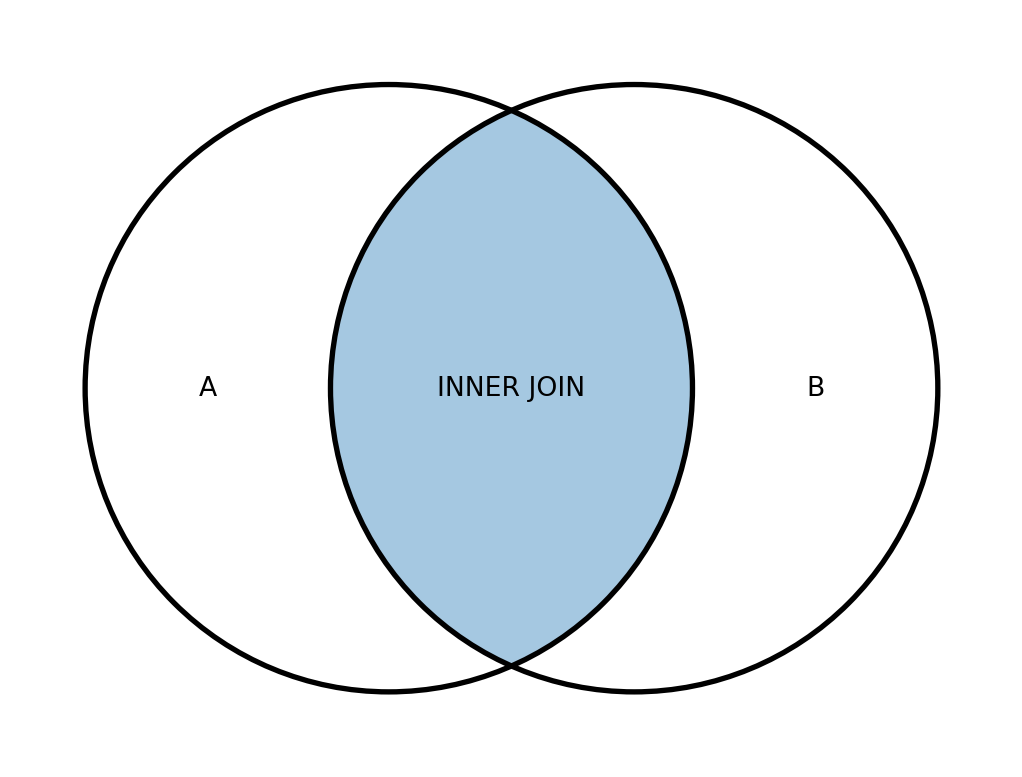

In [2]:
# | echo: false
# | label: sql_inner_join
# | fig-cap: "Діаграма Венна: INNER JOIN"

from matplotlib_venn import venn2, venn2_circles

v = venn2(subsets={"10": 1, "01": 1, "11": 1}, set_labels=("", ""))
c = venn2_circles(subsets=(1, 1, 1))
v.get_patch_by_id("10").set_alpha(1.0)
v.get_patch_by_id("10").set_color("white")
v.get_label_by_id("10").set_text("A")
v.get_patch_by_id("01").set_alpha(1.0)
v.get_patch_by_id("01").set_color("white")
v.get_label_by_id("01").set_text("B")
v.get_label_by_id("11").set_text("INNER JOIN")
v.get_patch_by_id("11").set_color("tab:blue")

::: {.callout-note}
Докладніше про `INNER JOIN` можна почитати [тут](https://duckdb.org/docs/sql/query_syntax/from#outer-joins).
:::

А тепер давайте повернемося до нашої бази даних та вирішимо завдання.

Для початку спробуйте виконати наступні два запити та порахувати кількість унікальних користувачів у таблицях `users` та `user_actions`:

In [3]:
%%sql
SELECT COUNT(DISTINCT user_id)
FROM users

,count(DISTINCT user_id)
0,20331


In [4]:
%%sql
SELECT COUNT(DISTINCT user_id)
FROM user_actions

,count(DISTINCT user_id)
0,21401


Ви помітите, що у таблиці `user_actions` унікальних користувачів більше. Це означає, що про частину користувачів ми щось не знаємо — у нас просто немає інформації в таблиці `users`. Тому в результаті об'єднання цих двох таблиць за допомогою `INNER JOIN` цю частину користувачів буде виключено з результату.

:::: {.callout-note icon=false}
## Завдання
::: {#exr-sql-join-01}
<br>
Об'єднайте таблиці `user_actions` та `users` за ключом `user_id`. У результаті включіть дві колонки з `user_id` з обох таблиць. Ці дві колонки назвіть відповідно `user_id_left` та `user_id_right`. Також у результат включіть колонки `order_id`, `time`, `action`, `sex`, `birth_date`. Відсортуйте таблицю за зростанням id користувача (у будь-якій з двох колонок з id).

Поля в результуючій таблиці: `user_id_left`, `user_id_right`, `order_id`, `time`, `action`, `sex`, `birth_date`

:::

::::

::: {.callout-note}
Зверніть увагу, що в результаті об'єднання колонки з ключами (у нашому випадку це `user_id`) не перетворюються на одну загальну колонку, а разом додаються в результуючу таблицю. Тобто скільки було сумарно колонок у двох таблицях, стільки виявиться і в результуючій таблиці після об'єднання. А вже далі в операторі `SELECT` можна вибирати потрібні та проводити над ними операції.

Щоб звернутися до колонок з однаковим ім'ям (`user_id`), що прийшли з різних таблиць, призначте таблицям аліаси та зверніться до колонок через них. Приклад, як це можна зробити:

```sql
SELECT A.id as id_a, 
       B.id as id_b, 
       ...
FROM table_A as A
     JOIN table_B as B
     ON A.id = B.id
...
```
:::

In [5]:
#| code-fold: true
#| code-summary: "Рішення"
#| column: body-outset

%%sql
SELECT a.user_id as user_id_left,
       b.user_id as user_id_right,
       order_id,
       time,
       action,
       sex,
       birth_date
FROM   user_actions a join users b using (user_id)
ORDER BY user_id_left

,user_id_left,user_id_right,order_id,time,action,sex,birth_date
0,1,1,1,2022-08-24 01:52:00,create_order,female,1991-10-23
1,1,1,4683,2022-08-27 20:56:00,create_order,female,1991-10-23
2,1,1,22901,2022-09-02 00:58:00,create_order,female,1991-10-23
3,1,1,23149,2022-09-02 02:36:00,create_order,female,1991-10-23
4,2,2,2,2022-08-24 06:37:00,create_order,female,1993-06-18
...,...,...,...,...,...,...,...
59341,21399,21399,59583,2022-09-08 23:56:00,create_order,female,1987-04-27
59342,21399,21399,59587,2022-09-08 23:58:00,create_order,female,1987-04-27
59343,21400,21400,59586,2022-09-08 23:57:00,create_order,male,1986-12-31
59344,21401,21401,59589,2022-09-08 23:58:00,create_order,female,1993-03-20
